<a href="https://colab.research.google.com/github/jumbokh/csu1112-class/blob/main/class/vision/dcgan_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

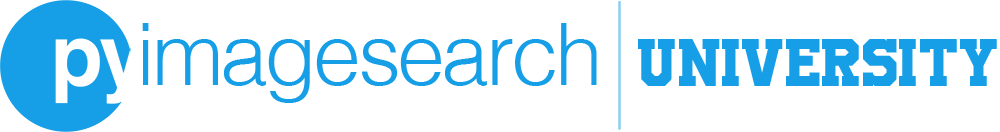

# Training a DCGAN in PyTorch
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [Training a DCGAN in PyTorch](https://www.pyimagesearch.com/2021/10/25/training-a-dcgan-in-pytorch/) blog post published on 2021-10-25.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2021 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

### Download the code zip file

In [1]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/dcgan-pytorch/dcgan-pytorch.zip
!unzip -qq dcgan-pytorch.zip
%cd dcgan-pytorch

--2023-05-13 03:18:28--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/dcgan-pytorch/dcgan-pytorch.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.211.50, 52.92.179.42, 52.218.169.137, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.211.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1707800 (1.6M) [binary/octet-stream]
Saving to: ‘dcgan-pytorch.zip’

dcgan-pytorch.zip   100%[===================>]   1.63M  4.50MB/s    in 0.4s    

2023-05-13 03:18:29 (4.50 MB/s) - ‘dcgan-pytorch.zip’ saved [1707800/1707800]

/content/dcgan-pytorch


## Blog Post Code

### Import Packages

In [2]:
# import the necessary packages
from IPython.display import Image
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
from sklearn.utils import shuffle
from imutils import build_montages
from torch.optim import Adam
from torch.nn import BCELoss
from torch.nn import ConvTranspose2d
from torch.nn import BatchNorm2d
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import LeakyReLU
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sigmoid
from torch import flatten
from torch import nn
import numpy as np
import argparse
import torch
import cv2
import os

In [3]:
# construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-o", "--output", required=True,
# 	help="path to output directory")
# ap.add_argument("-e", "--epochs", type=int, default=20,
# 	help="# epochs to train for")
# ap.add_argument("-b", "--batch-size", type=int, default=128,
# 	help="batch size for training")
# args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"output": "output",
    "epochs": 20,
    "batch-size": 128,
    "gif": "output.gif"
}

### Define the Generator

In [4]:
class Generator(nn.Module):
	def __init__(self, inputDim=100, outputDim=512, outputChannels=1):
		super(Generator, self).__init__()

		# first set of CONVT => RELU => BN
		self.ct1 = ConvTranspose2d(in_channels=inputDim,
			out_channels=128, kernel_size=4, stride=2, padding=0,
			bias=False)
		self.relu1 = ReLU()
		self.batchNorm1 = BatchNorm2d(128)

		# second set of CONVT => RELU => BN
		self.ct2 = ConvTranspose2d(in_channels=128, out_channels=64,
					kernel_size=3, stride=2, padding=1, bias=False)
		self.relu2 = ReLU()
		self.batchNorm2 = BatchNorm2d(64)

		# last set of CONVT => RELU => BN
		self.ct3 = ConvTranspose2d(in_channels=64, out_channels=32,
					kernel_size=4, stride=2, padding=1, bias=False)
		self.relu3 = ReLU()
		self.batchNorm3 = BatchNorm2d(32)

		# apply another upsample and transposed convolution, but
		# this time output the TANH activation
		self.ct4 = ConvTranspose2d(in_channels=32,
			out_channels=outputChannels, kernel_size=4, stride=2,
			padding=1, bias=False)
		self.tanh = Tanh()

	def forward(self, x):
		# pass the input through our first set of CONVT => RELU => BN
		# layers
		x = self.ct1(x)
		x = self.relu1(x)
		x = self.batchNorm1(x)

		# pass the output from previous layer through our second
		# CONVT => RELU => BN layer set
		x = self.ct2(x)
		x = self.relu2(x)
		x = self.batchNorm2(x)

		# pass the output from previous layer through our last set
		# of CONVT => RELU => BN layers
		x = self.ct3(x)
		x = self.relu3(x)
		x = self.batchNorm3(x)

		# pass the output from previous layer through CONVT2D => TANH
		# layers to get our output
		x = self.ct4(x)
		output = self.tanh(x)

		# return the output
		return output

### Define the Disciminator

In [5]:
class Discriminator(nn.Module):
	def __init__(self, depth, alpha=0.2):
		super(Discriminator, self).__init__()

		# first set of CONV => RELU layers
		self.conv1 = Conv2d(in_channels=depth, out_channels=32,
				kernel_size=4, stride=2, padding=1)
		self.leakyRelu1 = LeakyReLU(alpha, inplace=True)

		# second set of CONV => RELU layers
		self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=4,
				stride=2, padding=1)
		self.leakyRelu2 = LeakyReLU(alpha, inplace=True)

		# first (and only) set of FC => RELU layers
		self.fc1 = Linear(in_features=3136, out_features=512)
		self.leakyRelu3 = LeakyReLU(alpha, inplace=True)

		# sigmoid layer outputting a single value
		self.fc2 = Linear(in_features=512, out_features=1)
		self.sigmoid = Sigmoid()

	def forward(self, x):
		# pass the input through first set of CONV => RELU layers
		x = self.conv1(x)
		x = self.leakyRelu1(x)

		# pass the output from the previous layer through our second
		# set of CONV => RELU layers
		x = self.conv2(x)
		x = self.leakyRelu2(x)

		# flatten the output from the previous layer and pass it
		# through our first (and only) set of FC => RELU layers
		x = flatten(x, 1)
		x = self.fc1(x)
		x = self.leakyRelu3(x)

		# pass the output from the previous layer through our sigmoid
		# layer outputting a single value
		x = self.fc2(x)
		output = self.sigmoid(x)

		# return the output
		return output

### Custom weight initialization

In [6]:
# custom weights initialization called on generator and discriminator
def weights_init(model):
	# get the class name
	classname = model.__class__.__name__

	# check if the classname contains the word "conv"
	if classname.find("Conv") != -1:
		# intialize the weights from normal distribution
		nn.init.normal_(model.weight.data, 0.0, 0.02)

	# otherwise, check if the name contains the word "BatcnNorm"
	elif classname.find("BatchNorm") != -1:
		# intialize the weights from normal distribution and set the
		# bias to 0
		nn.init.normal_(model.weight.data, 1.0, 0.02)
		nn.init.constant_(model.bias.data, 0)

### Building the data pipeline

In [7]:
# store the epochs and batch size in convenience variables
NUM_EPOCHS = args["epochs"]
BATCH_SIZE = args["batch-size"]

# set the device we will be using
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define data transforms
dataTransforms = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5), (0.5))]
)

# load the MNIST dataset and stack the training and testing data
# points so we have additional training data
print("[INFO] loading MNIST dataset...")
trainData = MNIST(root="data", train=True, download=True,
	transform=dataTransforms)
testData = MNIST(root="data", train=False, download=True,
	transform=dataTransforms)
data = torch.utils.data.ConcatDataset((trainData, testData))

# initialize our dataloader
dataloader = DataLoader(data, shuffle=True,
	batch_size=BATCH_SIZE)

# calculate steps per epoch
stepsPerEpoch = len(dataloader.dataset) // BATCH_SIZE

[INFO] loading MNIST dataset...


100%|██████████| 9912422/9912422 [00:00<00:00, 102918583.06it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 23608593.61it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26078710.21it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4097769.15it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Training the model

In [8]:
# build the generator, initialize it's weights, and flash it to the
# current device
print("[INFO] building generator...")
gen = Generator(inputDim=100, outputDim=512, outputChannels=1)
gen.apply(weights_init)
gen.to(DEVICE)

# build the discriminator, initialize it's weights, and flash it to
# the current device
print("[INFO] building discriminator...")
disc = Discriminator(depth=1)
disc.apply(weights_init)
disc.to(DEVICE)

# initialize optimizer for both geneator and discriminator
genOpt = Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999),
	weight_decay=0.0002 / NUM_EPOCHS)
discOpt = Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999),
	weight_decay=0.0002 / NUM_EPOCHS)

# initialize BCELoss function
criterion = BCELoss()

# randomly generate some benchmark noise so we can consistently
# visualize how the generative modeling is learning
print("[INFO] starting training...")
benchmarkNoise = torch.randn(256, 100, 1, 1, device=DEVICE)

# define real and fake label values
realLabel = 1
fakeLabel = 0

# loop over the epochs
for epoch in range(NUM_EPOCHS):
	# show epoch information and compute the number of batches per
	# epoch
	print("[INFO] starting epoch {} of {}...".format(epoch + 1,
		NUM_EPOCHS))

	# initialize current epoch loss for generator and discriminator
	epochLossG = 0
	epochLossD = 0

	for x in dataloader:
		# zero out the discriminator gradients
		disc.zero_grad()

		# grab the images and send them to the device
		images = x[0]
		images = images.to(DEVICE)

		# get the batch size and create a labels tensor
		bs =  images.size(0)
		labels = torch.full((bs,), realLabel, dtype=torch.float,
			device=DEVICE)

		# forward pass through discriminator
		output = disc(images).view(-1)

		# calculate the loss on all-real batch
		errorReal = criterion(output, labels)

		# calculate gradients by performing a backward pass
		errorReal.backward()

		# randomly generate noise for the generator to predict on
		noise = torch.randn(bs, 100, 1, 1, device=DEVICE)

		# generate a fake image batch using the generator
		fake = gen(noise)
		labels.fill_(fakeLabel)

		# perform a forward pass through discriminator using fake
		# batch data
		output = disc(fake.detach()).view(-1)
		errorFake = criterion(output, labels)

		# calculate gradients by performing a backward pass
		errorFake.backward()

		# compute the error for discriminator and update it
		errorD = errorReal + errorFake
		discOpt.step()

		# set all generator gradients to zero
		gen.zero_grad()

		# update the labels as fake labels are real for the generator
		# and perform a forward pass  of fake data batch through the
		# discriminator
		labels.fill_(realLabel)
		output = disc(fake).view(-1)

		# calculate generator's loss based on output from
		# discriminator and calculate gradients for generator
		errorG = criterion(output, labels)
		errorG.backward()

		# update the generator
		genOpt.step()

		# add the current iteration loss of discriminator and
		# generator
		epochLossD += errorD
		epochLossG += errorG

	# display training information to disk
	print("[INFO] Generator Loss: {:.4f}, Discriminator Loss: {:.4f}".format(
		epochLossG / stepsPerEpoch, epochLossD / stepsPerEpoch))

	# check to see if we should visualize the output of the
	# generator model on our benchmark data
	if (epoch + 1) % 2 == 0:
		# set the generator in evaluation phase, make predictions on
		# the benchmark noise, scale it back to the range [0, 255],
		# and generate the montage
		gen.eval()
		images = gen(benchmarkNoise)
		images = images.detach().cpu().numpy().transpose((0, 2, 3, 1))
		images = ((images * 127.5) + 127.5).astype("uint8")
		images = np.repeat(images, 3, axis=-1)
		vis = build_montages(images, (28, 28), (16, 16))[0]

		# build the output path and write the visualization to disk
		p = os.path.join(args["output"], "epoch_{}.png".format(
			str(epoch + 1).zfill(4)))
		cv2.imwrite(p, vis)

		# set the generator to training mode
		gen.train()

[INFO] building generator...
[INFO] building discriminator...
[INFO] starting training...
[INFO] starting epoch 1 of 20...
[INFO] Generator Loss: 3.8114, Discriminator Loss: 0.5330
[INFO] starting epoch 2 of 20...
[INFO] Generator Loss: 1.0204, Discriminator Loss: 1.1476
[INFO] starting epoch 3 of 20...
[INFO] Generator Loss: 1.0035, Discriminator Loss: 1.1496
[INFO] starting epoch 4 of 20...
[INFO] Generator Loss: 1.0011, Discriminator Loss: 1.1581
[INFO] starting epoch 5 of 20...
[INFO] Generator Loss: 0.9914, Discriminator Loss: 1.1457
[INFO] starting epoch 6 of 20...
[INFO] Generator Loss: 1.0016, Discriminator Loss: 1.1471
[INFO] starting epoch 7 of 20...
[INFO] Generator Loss: 0.9982, Discriminator Loss: 1.1579
[INFO] starting epoch 8 of 20...
[INFO] Generator Loss: 1.0306, Discriminator Loss: 1.1371
[INFO] starting epoch 9 of 20...
[INFO] Generator Loss: 1.0559, Discriminator Loss: 1.1131
[INFO] starting epoch 10 of 20...
[INFO] Generator Loss: 1.0950, Discriminator Loss: 1.0900

### Visualize the GIF

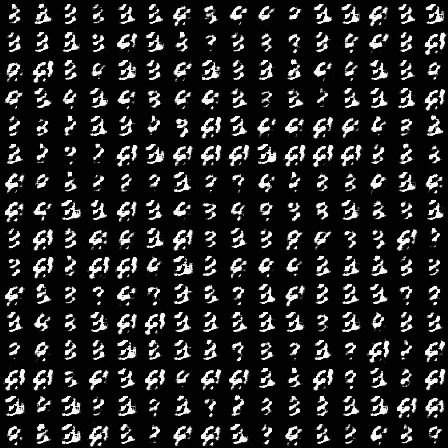

In [9]:
Image(open(args["gif"],"rb").read())

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Training a DCGAN in PyTorch*](https://www.pyimagesearch.com/2021/10/25/training-a-dcgan-in-pytorch/) published on 2021-10-25.

# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```